# U-Net Segmentation

In [1]:
# Google Drive setup
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import numpy as np
import cv2
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import random
import os

def load_coco_dataset(data_dir, annotation_file):
    # Initialize COCO api for instance annotations
    coco = COCO(annotation_file)

    # Load categories
    cat_ids = coco.getCatIds()
    cats = coco.loadCats(cat_ids)
    cat_names = [cat['name'] for cat in cats]
    cat_name_to_id = {cat['name']: cat['id'] for cat in cats}
    # print(cat_name_to_id)

    # Load image ids
    img_ids = coco.getImgIds()
    # print(img_ids)

    images = []
    masks = []

    for img_id in img_ids:
        # Load image
        img_info = coco.loadImgs(img_id)[0]
        img_path = f"{data_dir}/{img_info['file_name']}"
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Load annotations for the image
        ann_ids = coco.getAnnIds(imgIds=img_id, iscrowd=None)
        anns = coco.loadAnns(ann_ids)

        masks_image = []
        for ann in anns:
            mask = generate_mask(ann['segmentation'][0], (img_info['height'], img_info['width']))
            masks_image.append(mask)

        final_image_mask = add_up_masks(masks_image, (img_info['height'], img_info['width']))
        images.append(image)
        masks.append(final_image_mask)

    return images, masks, cat_name_to_id

def add_up_masks(masks_image, image_shape):
  merged_mask = np.zeros(image_shape[:2], dtype=np.uint8)
  for mask in masks_image:
      merged_mask = cv2.add(merged_mask, mask)
  return merged_mask

def generate_mask(points, image_shape):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    pts = np.array(points, np.int32)
    pts = pts.reshape((-1, 2))
    cv2.fillPoly(mask, [pts], color=(255))

    return mask


In [3]:
data_dir = '/content/gdrive/MyDrive/cell_nuclei_data/COCO_cell_nuclei/images'
annotation_file = '/content/gdrive/MyDrive/cell_nuclei_data/COCO_cell_nuclei/trainval.json'
images, masks, cat_name_to_id = load_coco_dataset(data_dir, annotation_file)

loading annotations into memory...
Done (t=1.27s)
creating index...
index created!


## Checking image and corresponding mask

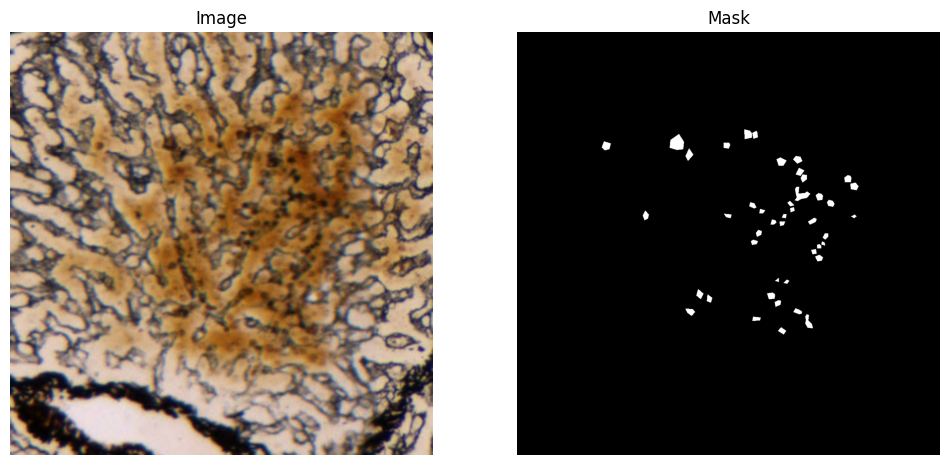

In [4]:
random_idx = random.randint(0, len(images)-1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(images[random_idx])
axes[0].set_title("Image")
axes[0].axis('off')
axes[1].imshow(masks[random_idx], cmap="gray")
axes[1].set_title("Mask")
axes[1].axis('off')
plt.show()

In [5]:
print(len(images))
print(len(masks))

100
100


## UNet

In [ ]:
# !pip install tensorflow[and-cuda]

In [6]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU, IoU
from keras.callbacks import History

In [7]:
def get_current_time_str():
  from datetime import datetime

  # Get current time
  now = datetime.now()

  # Some options:
  #  - "%Y-%m-%d %H:%M:%S"  # Year-Month-Day Hour:Minute:Second (e.g., 2024-04-04 15:49:23)
  #  - "%d/%m/%Y %H:%M:%S"  # Day/Month/Year Hour:Minute:Second (e.g., 04/04/2024 15:49:23)
  #  - "%H:%M:%S"          # Hour:Minute:Second (e.g., 15:49:23)
  time_string = now.strftime("%Y%m%d-%H:%M")

  return time_string


In [8]:
# If GPU is available, otherwise comment this section
from tensorflow.python.client import device_lib
import tensorflow as tf

print(device_lib.list_local_devices())
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available:", len(physical_devices))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2006942417305176683
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4633654581729639153
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
Num GPUs Available: 1


In [35]:
# from tensorflow.keras import backend as K
# smooth = 1.

# def dice_coef(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


# def dice_coef_loss(y_true, y_pred):
#     return -dice_coef(y_true, y_pred)

In [42]:
# Define the UNet architecture
def unet(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
    up6 = concatenate([up6, drop4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Load your train images and masks here
# Replace train_images and train_masks with your actual data
train_images = images
train_masks = masks

# Preprocess your data as needed (e.g., normalization, resizing)
def preprocess_images(image_list, new_size):
    preprocessed_images = []
    for img in image_list:
        # Resize image
        resized_img = cv2.resize(img, new_size)

        # Normalize pixel values to the range [0, 1]
        normalized_img = resized_img.astype(np.float32) / 255.0
        preprocessed_images.append(normalized_img)

    return preprocessed_images

train_images = preprocess_images(train_images, (256, 256))
train_masks = preprocess_images(train_masks, (256, 256))
# train_masks_resized = np.expand_dims(train_masks_resized, axis=-1)

# print(train_masks[0])
# print(train_images[0])

# Stack the lists of arrays into single arrays with an additional dimension
train_images_stacked = np.stack(train_images)
train_masks_stacked = np.stack(train_masks)

print(train_masks_stacked[0])

# Now, each array has a shape of (num_samples, height, width, channels) for images
# and (num_samples, height, width) for masks
# print(train_images_stacked.shape)
# print(train_masks_stacked.shape)

# Create and compile the model
model = unet(input_shape=(256, 256, 3))
# model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=[IoU(num_classes=2, target_class_ids=[1])])
# model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

print(len(train_images))
# plt.imshow(train_masks_resized[0])
# plt.show()

# Create a History callback instance
history = History()

train_masks_stacked = np.expand_dims(train_masks_stacked, axis=-1)
# print(train_masks_stacked.shape)
# print(train_images_stacked.shape)

# Train the model
model.fit(train_images_stacked,
          train_masks_stacked,
          batch_size=10,
          epochs=50,
          validation_split=0.2,
          callbacks=[history],
          shuffle=True)

# # Access the training metrics recorded by the History callback
# print(history.history.keys())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
100
Epoch 1/50
8/8 [==============================] - 11s 732ms/step - loss: 0.6214 - io_u_14: 0.0000e+00 - val_loss: 0.5538 - val_io_u_14: 0.0000e+00
Epoch 2/50
8/8 [==============================] - 5s 667ms/step - loss: 0.4385 - io_u_14: 0.0000e+00 - val_loss: 0.3132 - val_io_u_14: 0.0000e+00
Epoch 3/50
3/8 [==========>...................] - ETA: 3s - loss: 0.3018 - io_u_14: 0.0000e+00

KeyboardInterrupt: 

In [22]:
for image, mask in zip(train_images_stacked, train_masks_stacked):
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))
  axes[0].imshow(image)
  axes[0].set_title("Image")
  axes[0].axis('off')
  axes[1].imshow(mask, cmap="gray")
  axes[1].set_title("Mask")
  axes[1].axis('off')
  plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [28]:
# Saving model
model_name = get_current_time_str() + '_unet_cell_nuclei_10epochs.keras'
model_output_path = '/content/gdrive/MyDrive/cell_nuclei_data/output/unet/' + model_name
# print(os.path.exists(model_output_path))

model.save(model_output_path)

In [29]:
loss_values = history.history['loss']
accuracy_values = history.history['accuracy']
val_loss_values = history.history['val_loss']
val_accuracy_values = history.history['val_accuracy']

KeyError: 'accuracy'

### Visualizing results

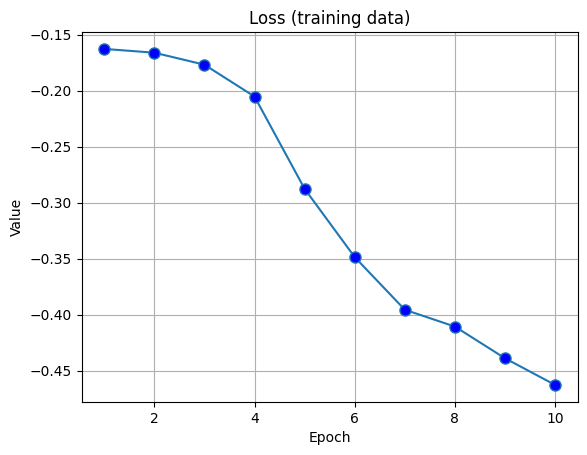

In [30]:
# Epochs (assuming they start from 1)
epochs = range(1, len(loss_values) + 1)  # Creates a sequence from 1 to the number of loss values

# Plot the loss values vs epochs
# plt.plot(epochs, loss_values)
plt.plot(epochs, loss_values, '-o', markersize=8, markerfacecolor='blue')

# Set the title and labels for the plot
plt.title("Loss (training data)")
plt.xlabel("Epoch")
plt.ylabel("Value")

# Show the plot
plt.grid(True)
plt.show()

In [31]:
# Epochs (assuming they start from 1)
epochs = range(1, len(accuracy_values) + 1)  # Creates a sequence from 1 to the number of loss values

# Plot the loss values vs epochs
plt.plot(epochs, accuracy_values, '-o', markersize=8, markerfacecolor='blue')

# Set the title and labels for the plot
plt.title("Accuracy (training data)")
plt.xlabel("Epoch")
plt.ylabel("Value")

# Show the plot
plt.grid(True)
plt.show()

NameError: name 'accuracy_values' is not defined

In [32]:
# Epochs (assuming they start from 1)
epochs = range(1, len(val_loss_values) + 1)  # Creates a sequence from 1 to the number of loss values

# Plot the loss values vs epochs
plt.plot(epochs, val_loss_values, '-o', markersize=8, markerfacecolor='blue')

# Set the title and labels for the plot
plt.title("Loss (validation data)")
plt.xlabel("Epoch")
plt.ylabel("Value")

# Show the plot
plt.grid(True)
plt.show()

NameError: name 'val_loss_values' is not defined

In [33]:
# Epochs (assuming they start from 1)
epochs = range(1, len(val_accuracy_values) + 1)  # Creates a sequence from 1 to the number of loss values

# Plot the loss values vs epochs
plt.plot(epochs, val_accuracy_values, '-o', markersize=8, markerfacecolor='blue')

# Set the title and labels for the plot
plt.title("Accuracy (validation data)")
plt.xlabel("Epoch")
plt.ylabel("Value")

# Show the plot
plt.grid(True)
plt.show()

NameError: name 'val_accuracy_values' is not defined

## Trying inference

In [34]:
from keras.models import load_model

my_model = load_model(model_output_path)

TypeError: Could not locate function 'dice_coef_loss'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'dice_coef_loss', 'registered_name': 'function'}

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np


img_path = '/content/gdrive/MyDrive/cell_nuclei_data/COCO_cell_nuclei/images/J7_25_a_ann0019.jpg'
img = load_img(img_path, target_size=(my_model.input_shape[1:3]))  # Match model input size
x = img_to_array(img)
x = x / 255.0  # Assuming model expects normalized values (0-1)
x = np.expand_dims(x, axis=0)

# Get segmentation mask
mask = my_model.predict(x)

1/1 [==============================] - 3s 3s/step


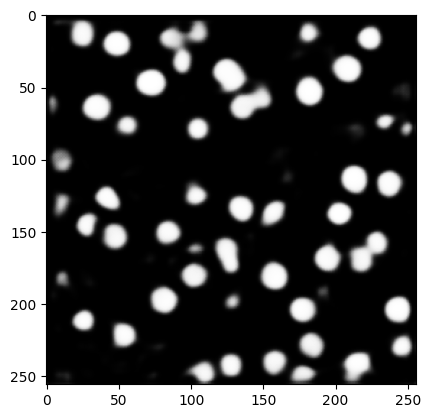

In [ ]:
mask = np.squeeze(mask, axis=0)
plt.imshow(mask, cmap="gray")
plt.show()

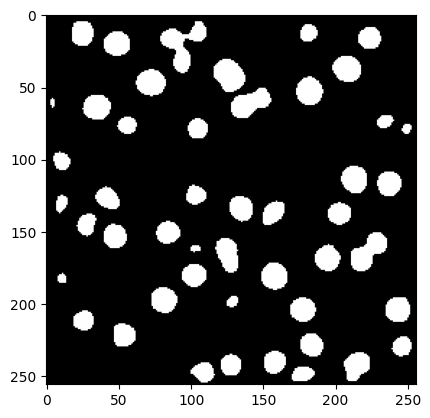

In [ ]:
# Thresholding output mask
threshold = 0.4  # You can adjust this value based on your needs
mask = (mask[..., 0] > threshold).astype(np.uint8)  # Assuming channel 0 and converting to uint8 for binary mask
plt.imshow(mask, cmap="gray")
plt.show()